In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import matplotlib.pyplot as plt
import json
%matplotlib inline


In [2]:
from sklearn.feature_selection import SelectKBest
from sklearn.cross_validation import train_test_split

ModuleNotFoundError: No module named 'sklearn.cross_validation'

In [3]:
def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # Setup map and marker
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot all samples
    X_test, y_test = X[test_idx, :], y[test_idx]
    for idx, c1 in enumerate(np.unique(y)):
        plt.scatter(x=X[y == c1, 0], y=X[y == c1, 1],
                   alpha=0.8, c=cmap(idx),
                   marker=markers[idx], label=c1)
    
    # highlight test samples
    if test_idx:
        X_test, y_test = X[test_idx, :], y[test_idx]
        plt.scatter(X_test[:, 0], X_test[:, 1], c='',
                    alpha=1.0, linewidth=1, marker='o', s=55, label='test set')

In [61]:
dataset = pd.read_json('sat_update.json')

In [62]:
dataset.head()

,INTLDES,NORAD_CAT_ID,OBJECT_TYPE,SATNAME,COUNTRY,LAUNCH,SITE,DECAY,PERIOD,INCLINATION,...,RCSVALUE,RCS_SIZE,FILE,LAUNCH_YEAR,LAUNCH_NUM,LAUNCH_PIECE,CURRENT,OBJECT_NAME,OBJECT_ID,OBJECT_NUMBER
0,1957-001A,1,ROCKET BODY,SL-1 R/B,CIS,1957-10-04,TTMTR,1957-12-01,96.19,65.10,...,0,LARGE,1,1957,1,A,Y,SL-1 R/B,1957-001A,1
1,1957-001B,2,PAYLOAD,SPUTNIK 1,CIS,1957-10-04,TTMTR,1958-01-03,96.10,65.00,...,0,None,7179,1957,1,B,Y,SPUTNIK 1,1957-001B,2
2,1957-002A,3,PAYLOAD,SPUTNIK 2,CIS,1957-11-03,TTMTR,1958-04-14,103.74,65.33,...,0,SMALL,5922,1957,2,A,Y,SPUTNIK 2,1957-002A,3
3,1958-001A,4,PAYLOAD,EXPLORER 1,US,1958-02-01,AFETR,1970-03-31,88.48,33.15,...,0,None,1,1958,1,A,Y,EXPLORER 1,1958-001A,4
4,1958-002B,5,PAYLOAD,VANGUARD 1,US,1958-03-17,AFETR,None,132.74,34.25,...,0,MEDIUM,7631,1958,2,B,Y,VANGUARD 1,1958-002B,5


In [63]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   INTLDES        1000 non-null   object 
 1   NORAD_CAT_ID   1000 non-null   int64  
 2   OBJECT_TYPE    1000 non-null   object 
 3   SATNAME        1000 non-null   object 
 4   COUNTRY        1000 non-null   object 
 5   LAUNCH         1000 non-null   object 
 6   SITE           1000 non-null   object 
 7   DECAY          710 non-null    object 
 8   PERIOD         958 non-null    float64
 9   INCLINATION    958 non-null    float64
 10  APOGEE         958 non-null    float64
 11  PERIGEE        958 non-null    float64
 12  COMMENT        42 non-null     object 
 13  COMMENTCODE    43 non-null     float64
 14  RCSVALUE       1000 non-null   int64  
 15  RCS_SIZE       411 non-null    object 
 16  FILE           1000 non-null   int64  
 17  LAUNCH_YEAR    1000 non-null   int64  
 18  LAUNCH_NU

In [64]:
dataset.describe()

,NORAD_CAT_ID,PERIOD,INCLINATION,APOGEE,PERIGEE,COMMENTCODE,RCSVALUE,FILE,LAUNCH_YEAR,LAUNCH_NUM,OBJECT_NUMBER
count,1000.000000,958.000000,958.000000,958.000000,958.000000,43.000000,1000.0,1000.000000,1000.00000,1000.000000,1000.000000
mean,500.500000,176.205407,66.993017,3232.918580,739.710856,4.790698,0.0,2923.248000,1962.22000,28.804000,500.500000
std,288.819436,850.096539,17.078934,22681.600267,3970.151048,0.709062,0.0,3515.537297,1.47573,21.805758,288.819436
min,1.000000,87.270000,2.330000,117.000000,23.000000,1.000000,0.0,1.000000,1957.00000,1.000000,1.000000
25%,250.750000,88.515000,58.512500,225.000000,171.000000,5.000000,0.0,1.000000,1961.00000,15.000000,250.750000
50%,500.500000,89.870000,66.570000,311.000000,208.000000,5.000000,0.0,1.000000,1962.00000,19.000000,500.500000
75%,750.250000,100.832500,80.460000,872.750000,612.250000,5.000000,0.0,7614.000000,1964.00000,45.000000,750.250000
max,1000.000000,21563.220000,114.970000,499998.000000,80504.000000,5.000000,0.0,7633.000000,1965.00000,87.000000,1000.000000


# Lets do some data explorartion

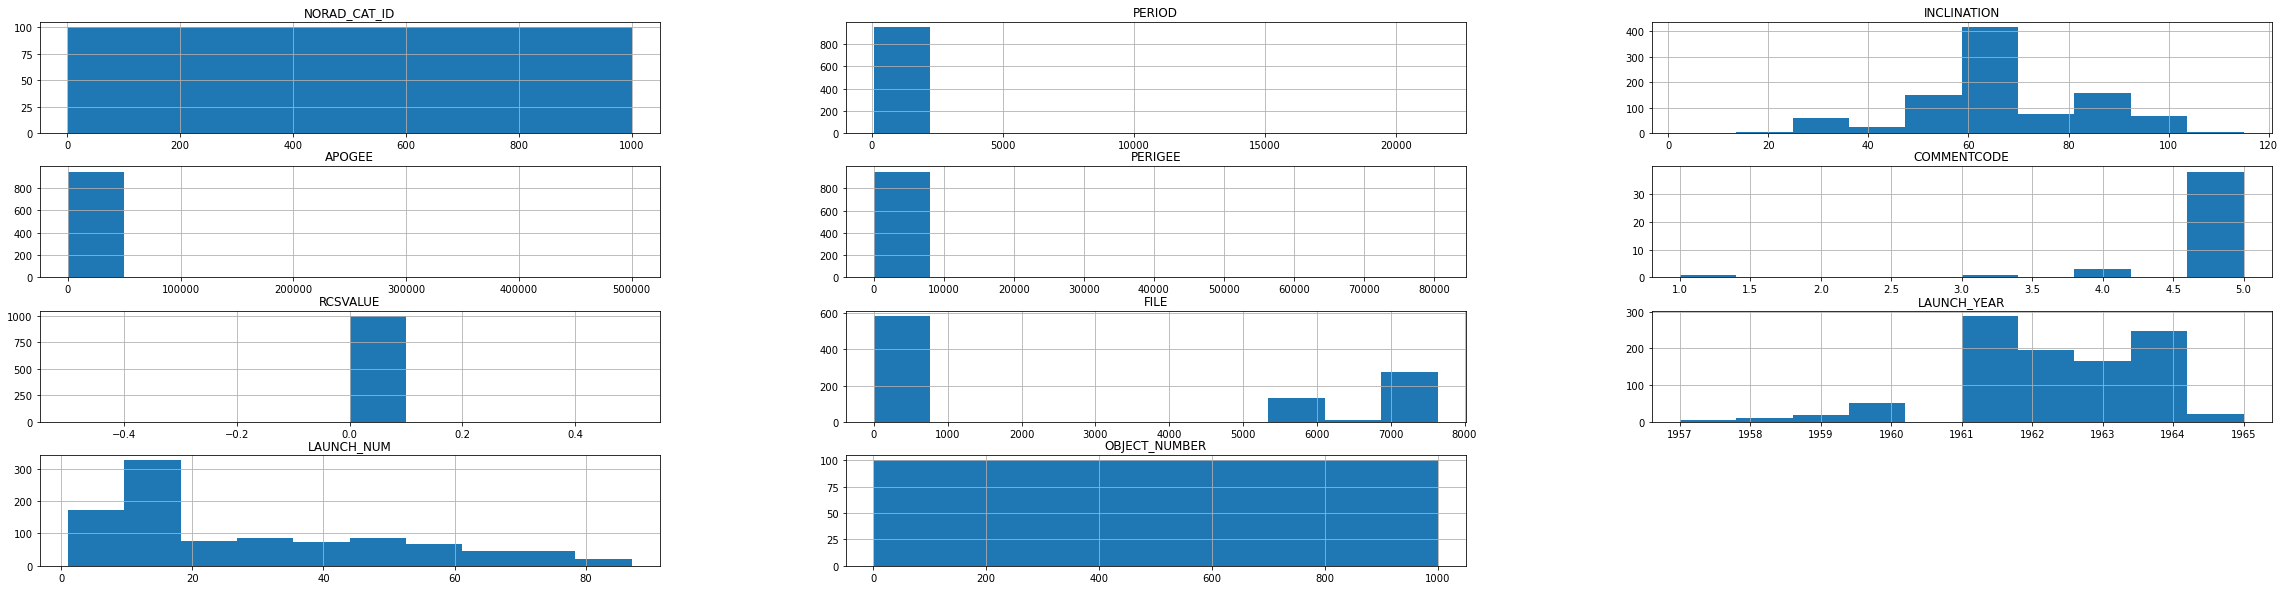

In [65]:
dataset.hist(figsize=(40,10))
plt.show()

In [83]:
corr_mat = dataset.corr()

## Which Countries have the most reported objects?

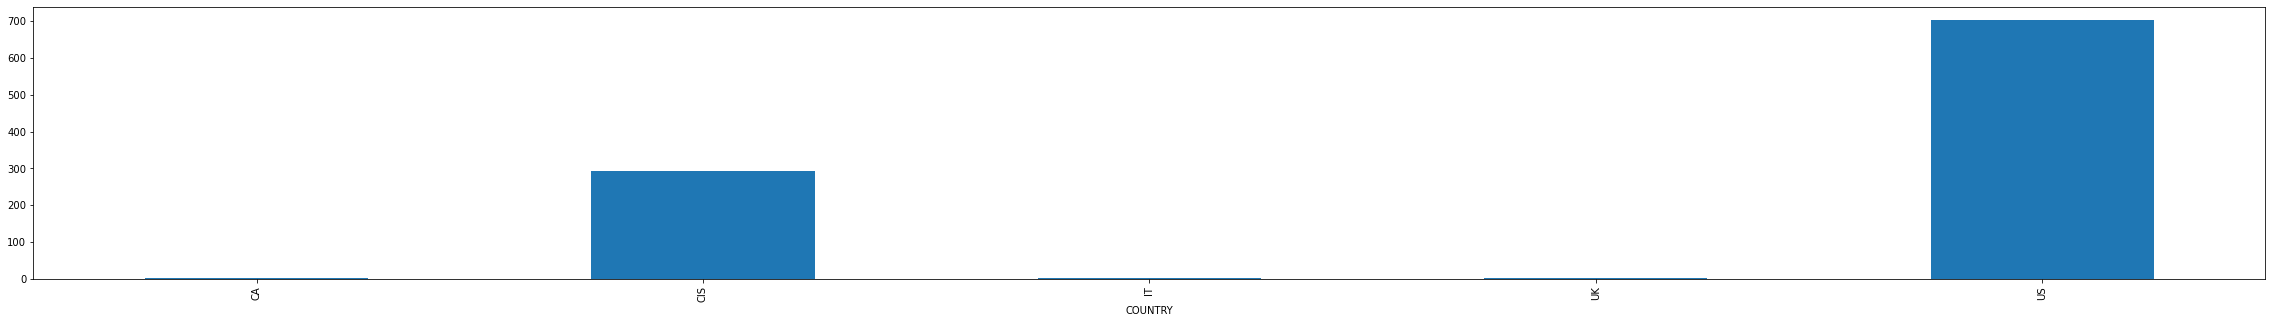

In [66]:
dfcountry = dataset.groupby(['COUNTRY'])['COUNTRY'].count()
dfcountry.plot(kind='bar')
plt.rcParams['figure.figsize'] = (40, 5)

In [67]:
dataset['COUNTRY'].value_counts()

US     703
CIS    293
UK       2
CA       1
IT       1
Name: COUNTRY, dtype: int64

Looking at the figure above, the Commenwealth of Independent states (CIS), US, and PRC respectivly, have the most reported objects.

<AxesSubplot:xlabel='OBJECT_TYPE'>

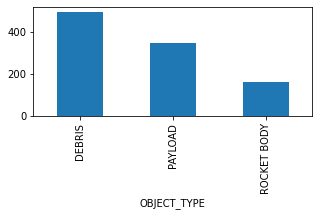

In [68]:
dfobjects = dataset.groupby(['OBJECT_TYPE'])['OBJECT_TYPE'].count()
dfobjects.plot(kind='bar', figsize=(5,2))

## Let's get a breakdown of the objects

In [69]:
dataset['OBJECT_TYPE'].value_counts()

DEBRIS         494
PAYLOAD        345
ROCKET BODY    161
Name: OBJECT_TYPE, dtype: int64

<AxesSubplot:xlabel='RCS_SIZE'>

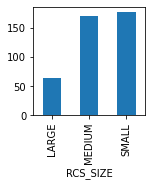

In [70]:
dfobjects = dataset.groupby(['RCS_SIZE'])['RCS_SIZE'].count()
dfobjects.plot(kind='bar', figsize=(2,2))

It looks like most of the objects are small and debris, which may pose issue with navigating around the debris for spacecraft.

# Lets see if we can gain some insights on the data by clustering

In [71]:
dataset['LAUNCH_PIECE'].value_counts()

A     299
B     209
C     113
D      77
E      33
     ... 
AQ      1
BX      1
FP      1
FZ      1
DF      1
Name: LAUNCH_PIECE, Length: 206, dtype: int64

In [72]:
dataset['SITE'].value_counts()

AFETR    368
AFWTR    325
TTMTR    238
KYMTR     55
WLPIS     14
Name: SITE, dtype: int64

In [73]:
df['DECAY'].value_counts()

Series([], Name: DECAY, dtype: int64)

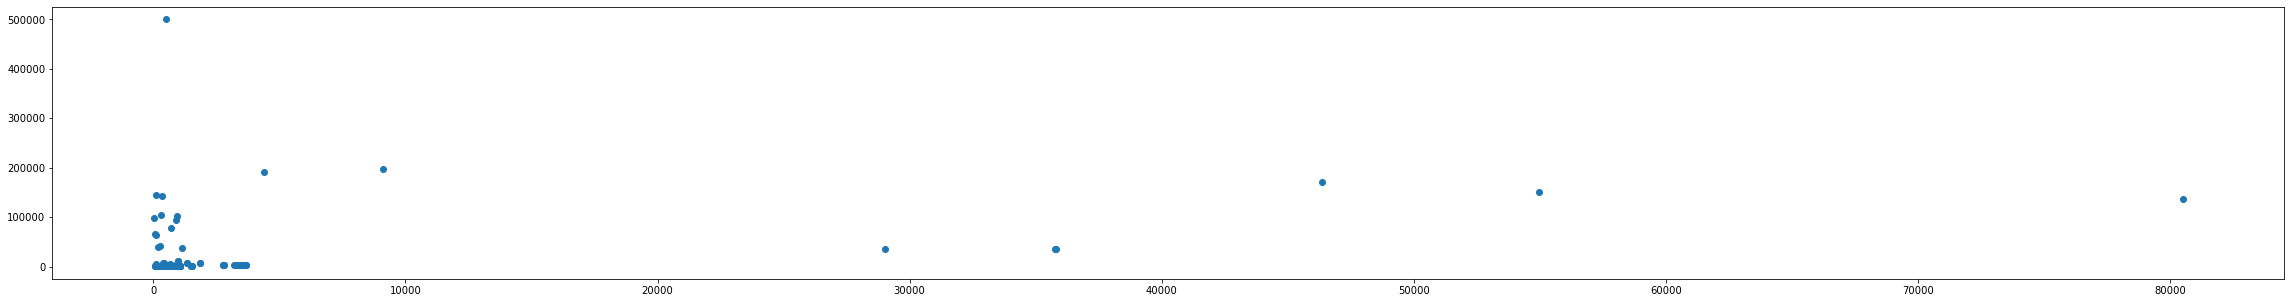

In [76]:
plt.scatter(dataset['PERIGEE'], dataset['APOGEE'])

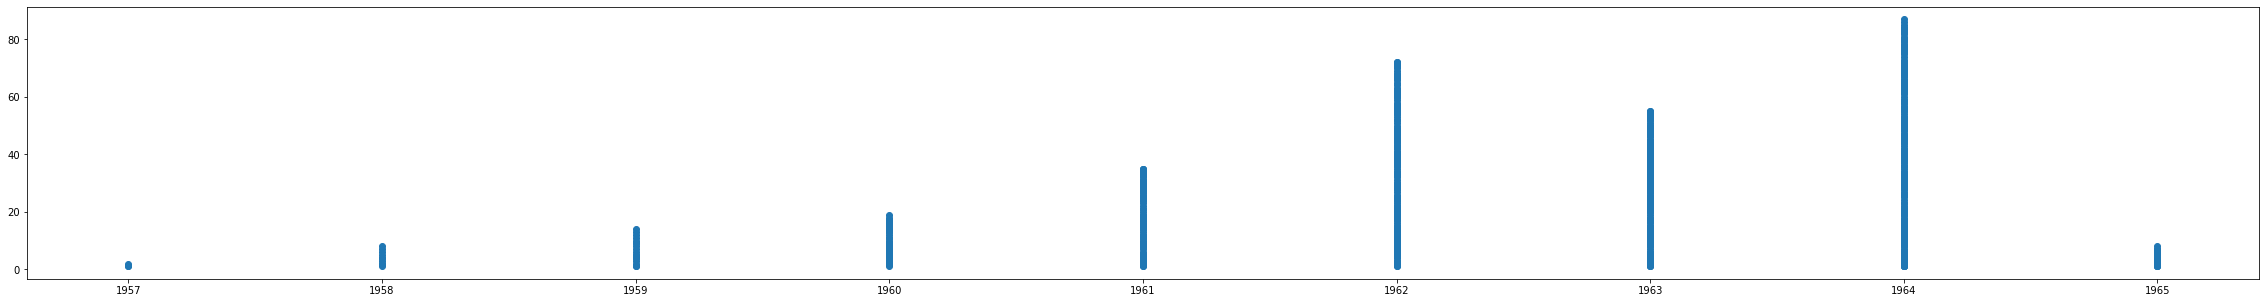

In [77]:
plt.scatter(dataset['LAUNCH_YEAR'],dataset['LAUNCH_NUM'])

# TIme to prepare the dataset and do some trimming

In [81]:
# drop some the columns that have no values or may not be relevant
df = dataset.drop(['NORAD_CAT_ID','COMMENT','COMMENTCODE','RCSVALUE','FILE','LAUNCH_NUM'], axis=1)
df['OBJECT_TYPE'].dropna(inplace=True)
df['RCS_SIZE'].dropna(inplace=True)
df.dropna()
df.head()

,INTLDES,OBJECT_TYPE,SATNAME,COUNTRY,LAUNCH,SITE,DECAY,PERIOD,INCLINATION,APOGEE,PERIGEE,RCS_SIZE,LAUNCH_YEAR,LAUNCH_PIECE,CURRENT,OBJECT_NAME,OBJECT_ID,OBJECT_NUMBER
0,1957-001A,ROCKET BODY,SL-1 R/B,CIS,1957-10-04,TTMTR,1957-12-01,96.19,65.10,938.0,214.0,LARGE,1957,A,Y,SL-1 R/B,1957-001A,1
1,1957-001B,PAYLOAD,SPUTNIK 1,CIS,1957-10-04,TTMTR,1958-01-03,96.10,65.00,1080.0,64.0,None,1957,B,Y,SPUTNIK 1,1957-001B,2
2,1957-002A,PAYLOAD,SPUTNIK 2,CIS,1957-11-03,TTMTR,1958-04-14,103.74,65.33,1659.0,211.0,SMALL,1957,A,Y,SPUTNIK 2,1957-002A,3
3,1958-001A,PAYLOAD,EXPLORER 1,US,1958-02-01,AFETR,1970-03-31,88.48,33.15,215.0,183.0,None,1958,A,Y,EXPLORER 1,1958-001A,4
4,1958-002B,PAYLOAD,VANGUARD 1,US,1958-03-17,AFETR,None,132.74,34.25,3834.0,649.0,MEDIUM,1958,B,Y,VANGUARD 1,1958-002B,5


In [86]:
df.columns

Index(['INTLDES', 'OBJECT_TYPE', 'SATNAME', 'COUNTRY', 'LAUNCH', 'SITE',
       'DECAY', 'PERIOD', 'INCLINATION', 'APOGEE', 'PERIGEE', 'RCS_SIZE',
       'LAUNCH_YEAR', 'LAUNCH_PIECE', 'CURRENT', 'OBJECT_NAME', 'OBJECT_ID',
       'OBJECT_NUMBER'],
      dtype='object')

In [91]:
# Lets attempt to cluster the objects based on the apogee and perigee

In [ ]:
# We can train a model to predict when an object will Decay (Regression, SVM, Decision Trees)
# Use the size, period, inclination, etc. to predict the object type

In [120]:
# Get the numerical values
debris_num = dataset.drop(['NORAD_CAT_ID','INTLDES', 'OBJECT_TYPE', 'SATNAME', 'COUNTRY', 'LAUNCH', 'SITE',
       'RCS_SIZE', 'LAUNCH_PIECE','COMMENT','COMMENTCODE','FILE','LAUNCH_NUM', 'CURRENT', 'OBJECT_NAME', 'OBJECT_ID',
       'OBJECT_NUMBER', 'RCSVALUE','DECAY'], axis=1)
debris_num.dropna(inplace=True)
debris_num.head()

,PERIOD,INCLINATION,APOGEE,PERIGEE,LAUNCH_YEAR
0,96.19,65.10,938.0,214.0,1957
1,96.10,65.00,1080.0,64.0,1957
2,103.74,65.33,1659.0,211.0,1957
3,88.48,33.15,215.0,183.0,1958
4,132.74,34.25,3834.0,649.0,1958


In [141]:
from sklearn.preprocessing import StandardScaler
std_sc = StandardScaler()
launch = pd.to_datetime(debris_num['LAUNCH_YEAR'], format='%Y').apply(lambda x: x.toordinal())
ap = np.array(debris_num['APOGEE']).reshape(-1,1)
ap = std_sc.fit_transform(ap)
pe = np.array(debris_num['PERIGEE']).reshape(-1,1)
pe = std_sc.fit_transform(pe)
inc = np.array(debris_num['INCLINATION']).reshape(-1,1)
inc = std_sc.fit_transform(inc)
per = np.array(debris_num['PERIOD']).reshape(-1,1)
per = std_sc.fit_transform(per)
debris_reg = pd.concat([pd.DataFrame(per, columns=['PERIOD']), pd.DataFrame(inc, columns=['INCLINATION']), 
                 pd.DataFrame(pe, columns=['PERIGEE']), pd.DataFrame(ap, columns=['APOGEE']), pd.DataFrame(launch)], axis=1)
debris_reg.head()


,PERIOD,INCLINATION,PERIGEE,APOGEE,LAUNCH_YEAR
0,-0.094174,-0.110897,-0.132485,-0.101233,714415.0
1,-0.094280,-0.116755,-0.170287,-0.094969,714415.0
2,-0.085288,-0.097423,-0.133241,-0.069428,714415.0
3,-0.103249,-1.982600,-0.140297,-0.133125,714780.0
4,-0.051157,-1.918159,-0.022860,0.026515,714780.0


In [110]:
# one hot encode the RCS size
from sklearn.preprocessing import OneHotEncoder
rcs_cat = dataset['RCS_SIZE']
obj_cat = dataset['OBJECT_TYPE']
obj_onehot = pd.get_dummies(obj_cat)
rcs_onehot = pd.get_dummies(rcs_cat)
encoded = pd.concat([obj_onehot, rcs_onehot], axis=1)


,DEBRIS,PAYLOAD,ROCKET BODY,LARGE,MEDIUM,SMALL
0,0,0,1,1,0,0
1,0,1,0,0,0,0
2,0,1,0,0,0,1
3,0,1,0,0,0,0
4,0,1,0,0,1,0


In [109]:
rcs_onehot

,LARGE,MEDIUM,SMALL
0,1,0,0
1,0,0,0
2,0,0,1
3,0,0,0
4,0,1,0
...,...,...,...
995,0,0,0
996,0,0,0
997,0,0,0
998,0,0,0


In [ ]:
# Use the transformaer to combine the categorical and numerical data
from sklearn.compose import ColumnTransformer
num_attributes = list(debris_num)
cat_attributes = ["RCS_SIZE", "OBJECT_TYPE"]

pipeline = ColumnTransformer([
            ("num", num_pipeline, num_attributes),
            ("cat", encoded)
])



In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor


forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

In [400]:
# Use k-means clustering to cluster the dataset
from sklearn import cluster

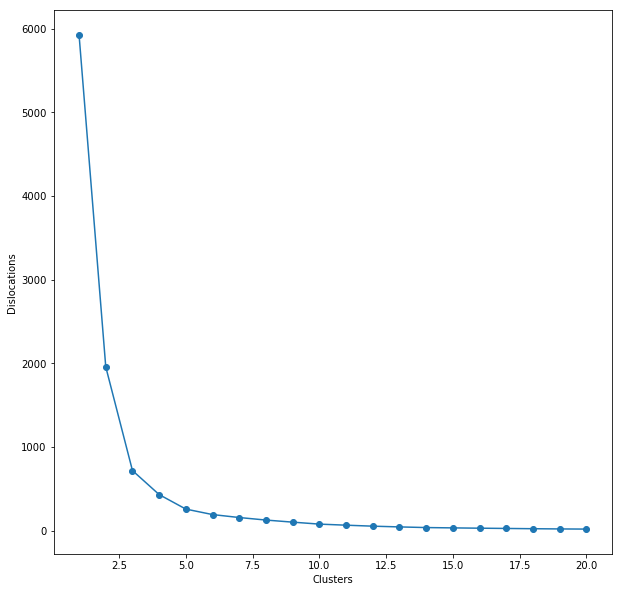

In [401]:
# Find where the number of clusters improve
distortions_obj = []
for i in range(1,21):
    km = cluster.KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=300, random_state=0, n_jobs=-1)
    km.fit(obj_labl)
    distortions_obj.append(km.inertia_)
plt.plot(range(1,21), distortions_obj, marker='o')
plt.xlabel('Clusters')
plt.ylabel('Dislocations')
plt.show()

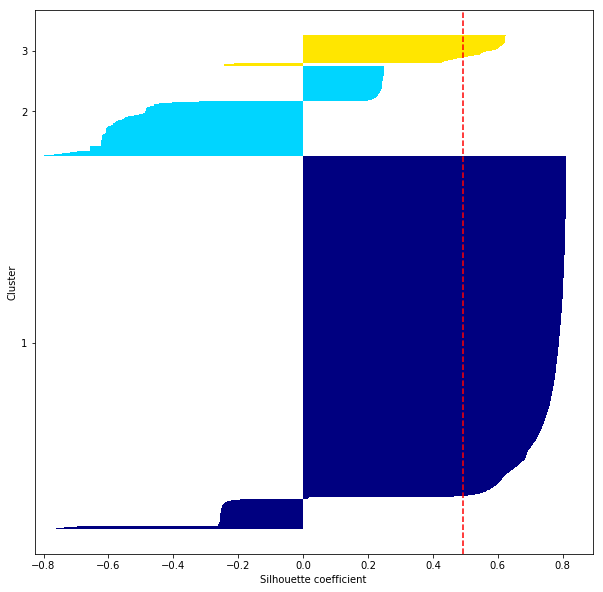

In [402]:
# create a sillouite plot
km = cluster.KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=500, random_state=0, n_jobs=-1)
y_km = km.fit_predict(obj_labl)

from matplotlib import cm
from sklearn.metrics import silhouette_samples
cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(labl_data, y_km, metric='euclidean')

y_ax_low, y_ax_up = 0, 0
y_ticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_up += len(c_silhouette_vals)
    color = cm.jet(i / n_clusters)
    plt.barh(range(y_ax_low, y_ax_up), c_silhouette_vals, height=1.0, edgecolor='none', color=color)
    y_ticks.append((y_ax_low + y_ax_up) / 2) 
    y_ax_low += len(c_silhouette_vals)
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color='red', linestyle="--")
plt.yticks(y_ticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')
plt.show()

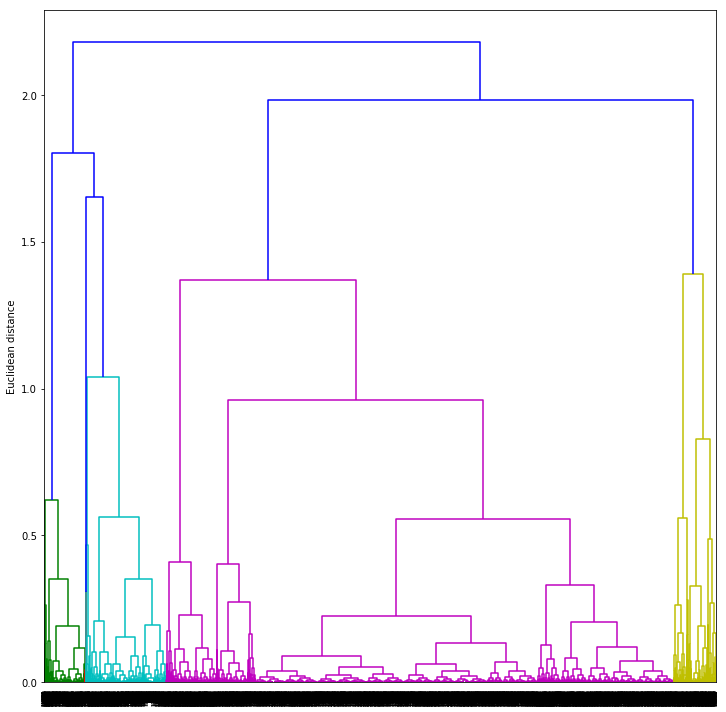

In [404]:
row_clusters = linkage(obj_labl.values,method='complete', metric='euclidean')
row_dendr = dendrogram(row_clusters)
plt.tight_layout()
plt.ylabel('Euclidean distance')
plt.show()

In [389]:
# Split into training and test data
# X = dataset.RCS_SIZE

# labl_data = pd.get_dummies(clus_data[['RCS_SIZE', 'orbit_speed']])
labl_data = pd.get_dummies(clus_data[['RCS_SIZE','orbit_speed']])

# Y = orbit_speed
labl_data.head()

,orbit_speed,RCS_SIZE_LARGE,RCS_SIZE_MEDIUM,RCS_SIZE_SMALL
0,0.875403,0,0,1
1,0.874975,0,0,1
2,1.203773,0,0,1
3,0.631864,0,0,1
4,1.357929,0,0,1


(<matplotlib.collections.PathCollection at 0x7fc5c25e6550>,)

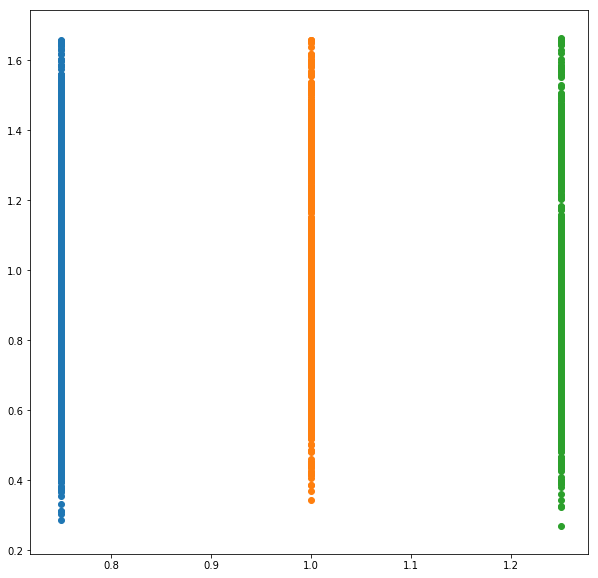

In [392]:
plt.scatter(labl_data.RCS_SIZE_SMALL[labl_data.RCS_SIZE_SMALL == 1] - .25, orbit_speed[labl_data.RCS_SIZE_SMALL == 1])
plt.scatter(labl_data.RCS_SIZE_MEDIUM[labl_data.RCS_SIZE_MEDIUM == 1], orbit_speed[labl_data.RCS_SIZE_MEDIUM == 1]),
plt.scatter(labl_data.RCS_SIZE_LARGE[labl_data.RCS_SIZE_LARGE == 1]+.25, orbit_speed[labl_data.RCS_SIZE_LARGE == 1]),


In [343]:
# Train the dataset using k-means
k_means = cluster.KMeans(n_clusters=3, random_state=0, n_jobs=-1, n_init=10, max_iter=500)
y_km = k_means.fit_predict(labl_data)


In [344]:
# plt.scatter(labl_data[y_km==0,0], labl_data[y_km==0,1], 
#            s=50, c='lightgreen', marker='s', label='cluster 1')
# plt.scatter(labl_data[y_km==1,0], labl_data[y_km==1,1], 
#            s=50, c='lightblue', marker='o', label='cluster 1')
# plt.scatter(labl_data[y_km==2,0], labl_data[y_km==2,1], 
#            s=50, c='orange', marker='v', label='cluster 1')
# plt.scatter(k_means.cluster_centers_[:,0], k_means.cluster_centers_[:,1],
#             s=50, marker='*', c='red', label='centroids')
# plt.legend()
# plt.grid()
# plt.show()

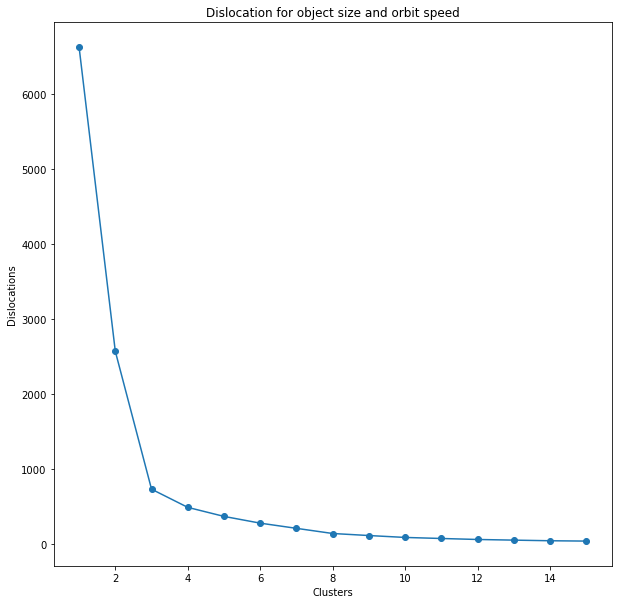

In [345]:
# Find where the number of clusters improve
distortions = []
for i in range(1,16):
    km = cluster.KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=300, random_state=0, n_jobs=-1)
    km.fit(labl_data)
    distortions.append(km.inertia_)
plt.plot(range(1,16), distortions, marker='o')
plt.xlabel('Clusters')
plt.ylabel('Dislocations')
plt.title('Dislocation for object size and orbit speed')
plt.show()

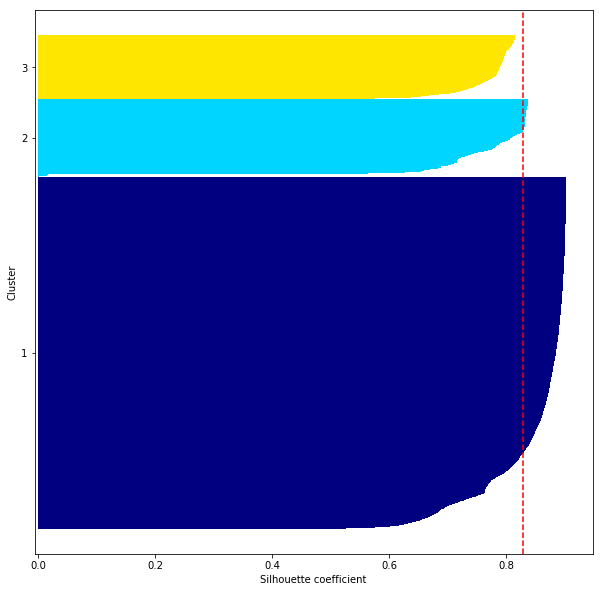

In [346]:
# create a sillouite plot
km = cluster.KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=500, random_state=0, n_jobs=-1)
y_km = km.fit_predict(labl_data)

from matplotlib import cm
from sklearn.metrics import silhouette_samples
cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(labl_data, y_km, metric='euclidean')

y_ax_low, y_ax_up = 0, 0
y_ticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_up += len(c_silhouette_vals)
    color = cm.jet(i / n_clusters)
    plt.barh(range(y_ax_low, y_ax_up), c_silhouette_vals, height=1.0, edgecolor='none', color=color)
    y_ticks.append((y_ax_low + y_ax_up) / 2) 
    y_ax_low += len(c_silhouette_vals)
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color='red', linestyle="--")
plt.yticks(y_ticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')
plt.show()

TypeError: scatter() missing 1 required positional argument: 'y'

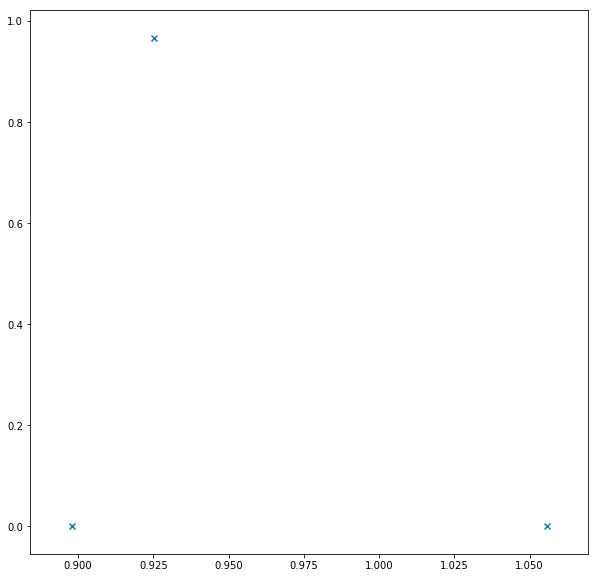

In [347]:
centroids = k_means.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:,1], marker='x' )
plt.scatter(y_km[0])
plt.show()

In [ ]:
# # assignment, cdist = cluster.vq.vq(X_train, Y_train)
# pyplot.scatter(X_train['SMALL'], Y_train)
# pyplot.scatter(Y_train, X_train['MEDIUM'])
# pyplot.scatter(X_train['LARGE'], Y_train)
# pyplot.show()

In [348]:
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage

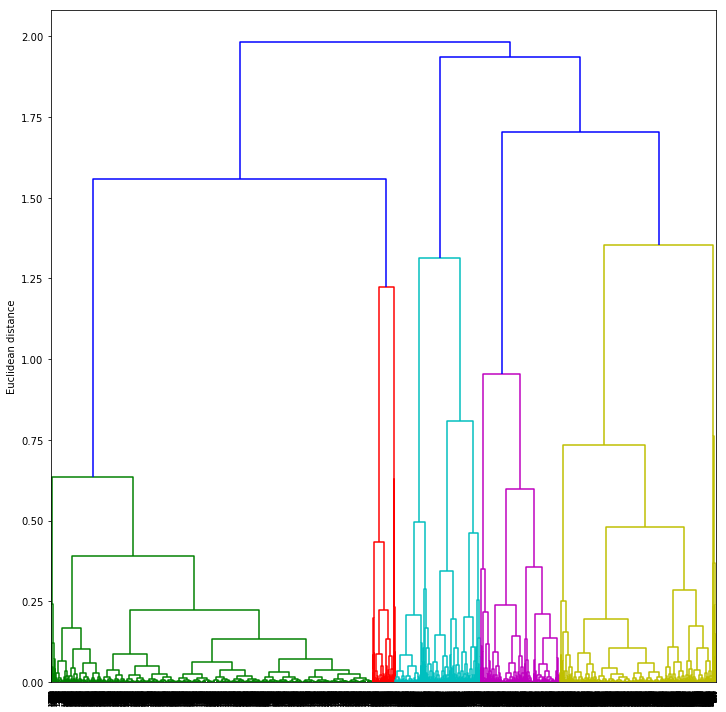

In [405]:
row_clusters = linkage(labl_data.values,method='complete', metric='euclidean')
row_dendr = dendrogram(row_clusters)
plt.tight_layout()
plt.ylabel('Euclidean distance')
plt.show()

In [350]:
from sklearn.cluster import AgglomerativeClustering
ac = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='complete')
labels = ac.fit_predict(labl_data)
print(labels)

[1 1 0 ..., 2 2 2]
